# APPLICATION OF FACEBOOK' S P ROPHET ALGORITHM FOR SUCCESSFUL SALES FORECASTING BASED ON REAL - WORLD DATA

## Requirements

In [1]:
#pip install pandas
#pip install fbprophet
#pip install plotly

## Importing required modules

In [2]:
# Import modules
import pandas as pd 
from fbprophet import Prophet 
from fbprophet.plot import add_changepoints_to_plot
from sklearn.metrics import mean_squared_error, mean_absolute_error 
import numpy as np 


Importing plotly failed. Interactive plots will not work.


## Reading the CSV - Avocado Sales

In [3]:
# Read Data
data = pd.read_csv("data/avocado.csv")
data.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


### Data Preprocessing

We should aggregate data accordingly to our objective. In this example we will aggregate data per month since it is a good scale to analyse the sails of a fruit.

### Feature Selection

Our dataset has information relating several avocado types as well as volume of sails and price. 

On the recomended paper it is said: 

"

Based on industry experience and discussion with clients in real field, it was concluded that
several different criteria can be used to sort the product portfolio by relevance:

1. the total profit per product over the last year (if the profit per sale is available, which is
a rarity),
2. the total financial turnover (i.e. net sales) per product over the last year (if the unit price
per sale is available, which is often a case),
3. the total quantity sold per item over the last year (if none of the aforementioned data is
available).

"

Since our dataset does not have any information relating the profit per sail, we will have to go for the second option which is to use the total financial turnover.


In [4]:
data['Date'] = data['Date'].str[:-3] #Remove day
data['TurnOver'] = data['AveragePrice'] * data['Total Volume']   #Turn over

aggregation_functions = {'TurnOver': 'sum'}
data = data.groupby(data['Date']).aggregate(aggregation_functions).reset_index()
data.head()

,Date,TurnOver
0,2015-01,3.235693e+08
1,2015-02,3.534159e+08
2,2015-03,4.303083e+08
3,2015-04,3.643787e+08
4,2015-05,4.978038e+08


## Creating the dataframe
We convert the data into the convention of ds (date timeseries) and y (output) to be predicted.  
In this case, it is the number of monthly car sales.

In [5]:
df = pd.DataFrame() 
df['ds'] = pd.to_datetime(data['Date']) 
df['y'] = data['TurnOver'] 
df.head()

,ds,y
0,2015-01-01,3.235693e+08
1,2015-02-01,3.534159e+08
2,2015-03-01,4.303083e+08
3,2015-04-01,3.643787e+08
4,2015-05-01,4.978038e+08


To test our model we decided to split the data in train and test where the test data will be the last 3 months

In [6]:
split_date = "2018-01-01"
df_train = df[df['ds'] < split_date].copy()
df_test = df[df['ds'] >= split_date].copy()


## Initialize the model
Here we initialize the model and fit the dataframe to it.

In [7]:
m = Prophet() 
m.fit(df_train) 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Testing

After the model fitted the training dataset we compared the results with the real values

In [8]:
forecast = m.predict(df_test) 
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01,5.228662e+08,5.180972e+08,6.027678e+08,5.228661e+08,5.228663e+08,3.702316e+07,3.702316e+07,3.702316e+07,3.702316e+07,3.702316e+07,3.702316e+07,0.0,0.0,0.0,5.598894e+08
1,2018-02-01,5.280796e+08,4.721811e+08,5.531641e+08,5.280791e+08,5.280801e+08,-1.547779e+07,-1.547779e+07,-1.547779e+07,-1.547779e+07,-1.547779e+07,-1.547779e+07,0.0,0.0,0.0,5.126019e+08
2,2018-03-01,5.327885e+08,5.079087e+08,5.955599e+08,5.327876e+08,5.327894e+08,1.765087e+07,1.765087e+07,1.765087e+07,1.765087e+07,1.765087e+07,1.765087e+07,0.0,0.0,0.0,5.504394e+08


MAPE is used to quantify the overall accuracy of the forecasting framework and calculate the expected
level of reliability.  
According to the paper approximately 50% of the products (with a sufficiently long historical data) can be forecasted with MAPE < 30% on monthly basis.   
Also, the the best selling products will have a lower MAPE.

In [9]:
def mean_abs_perc_err(y_true, y_pred):  
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("Mean Squared Error (MSE):", mean_squared_error(y_true = df_test["y"], y_pred = forecast['yhat'])) 
print("Mean Absolute Error (MAE):", mean_absolute_error(y_true = df_test["y"], y_pred = forecast['yhat'])) 
print("Mean Absolute % Error (MAPE): ", mean_abs_perc_err(y_true = np.asarray(df_test["y"]), y_pred = np.asarray(forecast['yhat'])))

Mean Squared Error (MSE): 2725440133959706.0
Mean Absolute Error (MAE): 46862677.07988974
Mean Absolute % Error (MAPE):  9.50864121726191


## Generate the future dataframe
Here, we create predictions for the next 5 years, and since the frequency is monthly, we need to create 12*5 periods

In [10]:
m = Prophet() 
m.fit(df) #retrain for all the dataset 

future = m.make_future_dataframe(periods=12*5, freq='M')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Analyze predictions

### Prophet forecasts

In [11]:
forecast = m.predict(future) 
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
94,2022-10-31,8.430033e+08,8.005288e+08,8.864411e+08,7.802770e+08,7.802763e+08,7.802777e+08
95,2022-11-30,6.678358e+08,6.238997e+08,7.099276e+08,7.848222e+08,7.848215e+08,7.848228e+08
96,2022-12-31,7.532142e+08,7.147104e+08,7.975625e+08,7.895189e+08,7.895181e+08,7.895195e+08
97,2023-01-31,7.340684e+08,6.923601e+08,7.759262e+08,7.942155e+08,7.942148e+08,7.942162e+08
98,2023-02-28,8.951404e+08,8.510297e+08,9.396618e+08,7.984577e+08,7.984569e+08,7.984584e+08


### Plotting the model

The below image shows the basic prediction. The light blue is the uncertainty level(yhat_upper and yhat_lower), the dark blue is the prediction(yhat) and the black dots are the original data. We can see that the predicted data is very close to the actual data. In the last five years, there is no “actual” data, but looking at the performance of our model in years where data is available it is safe to say that the predictions are close to accurate.

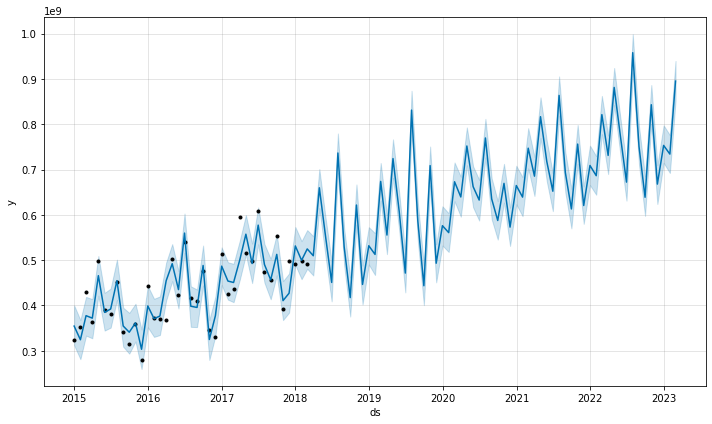

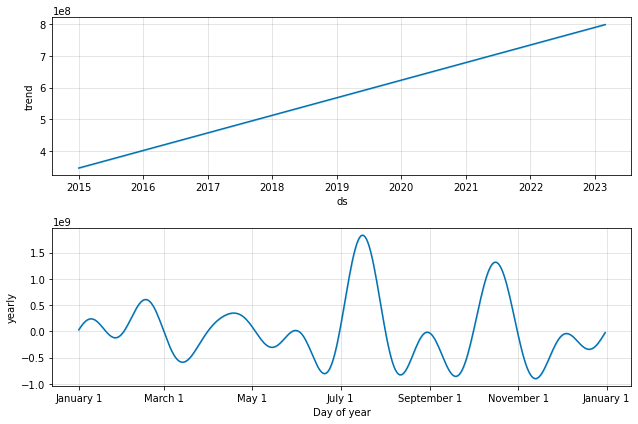

In [12]:
fig = m.plot(forecast) 

fig2 = m.plot_components(forecast) 

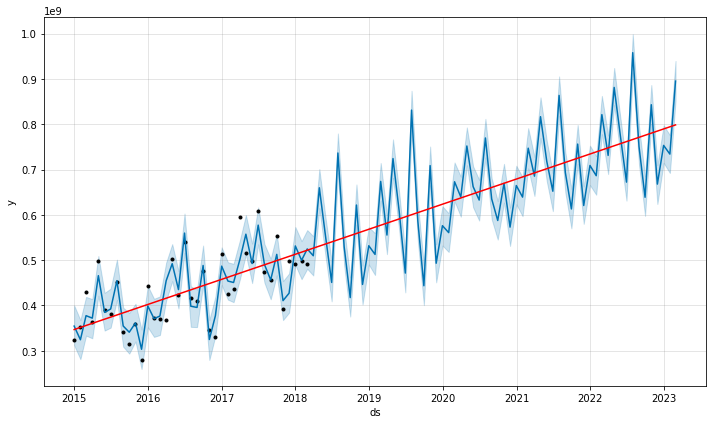

In [13]:
# Adding changepoints

fig = m.plot(forecast) 
a = add_changepoints_to_plot(fig.gca(), m, forecast)

## Using the model in a different way

Prophet can be used in a variaty of ways to best predict what a certain company decides to predict about their sales. In the last example we perdicted the monthly financial turnover but,  if required, this tool can be used to predict other parameters.  

As another example we will predict the daily volume of products sold for the next week, based on the last month of sales.

Since we are predicting the total number of sales daily, the model will be better if we train it with daily sales as well.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


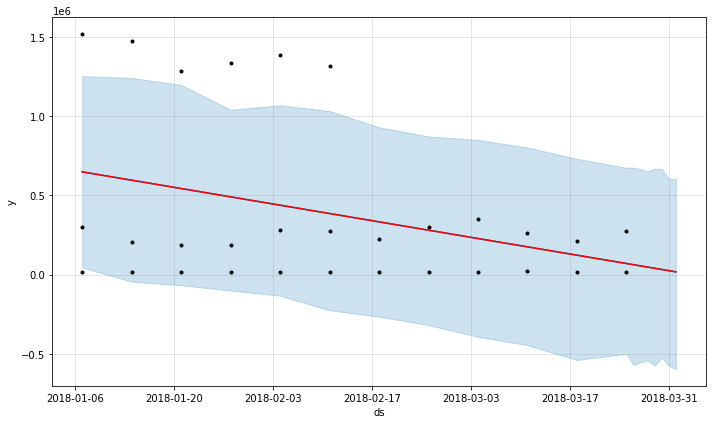

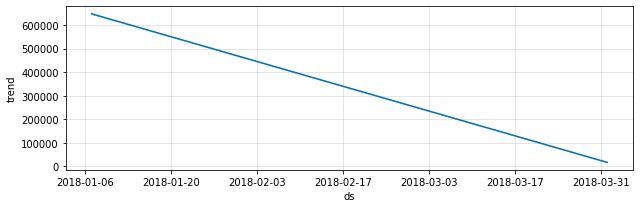

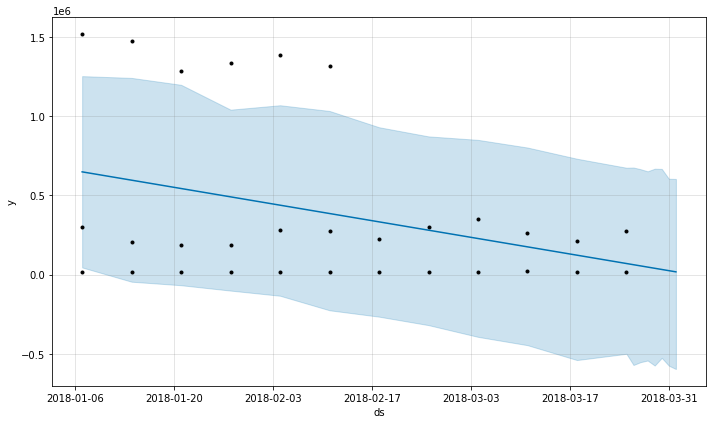

In [14]:
# Read Data
data = pd.read_csv("data/avocado.csv")   #Data was aggregated, need to read it again
data = data.tail(30)#last 30 days

df = pd.DataFrame() 
df['ds'] = pd.to_datetime(data['Date']) 
df['y'] = data['Total Volume'] 

m = Prophet() 
m.fit(df)
future = m.make_future_dataframe(periods=7, freq='D')  #Predict the next 20 days
forecast = m.predict(future) 
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper']].tail()

fig = m.plot(forecast) 
fig2 = m.plot_components(forecast) 
fig3 = m.plot(forecast) 
a = add_changepoints_to_plot(fig.gca(), m, forecast)
